In [49]:
import sqlite3
import pandas as pd

df = pd.read_csv("/kaggle/input/safebooru-2018/safebooru-metadata-2018.csv")
print(df.head(5))
print(df.columns)

        id  creator_id                      created_at  width  height  \
0  2552798          79  Sat May 26 09:30:08 +0200 2018    610    1000   
1  2552797          79  Sat May 26 09:30:07 +0200 2018    750    1113   
2  2552796          79  Sat May 26 09:30:06 +0200 2018    691    1100   
3  2552795          79  Sat May 26 09:30:06 +0200 2018    800    1086   
4  2552794          79  Sat May 26 09:30:04 +0200 2018    739    1204   

                                                tags  \
0   1girl blush bow collared_shirt from_behind gr...   
1   1girl artist_name bangle black_hair black_nai...   
2   1girl :d black_blazer blazer bow brown_cardig...   
3   1girl altera_(fate) bangs bare_shoulders blac...   
4   1girl adjusting_eyewear bangs blue_hair breas...   

                                              source  \
0  http://www.pixiv.net/member_illust.php?mode=me...   
1  http://www.pixiv.net/member_illust.php?mode=me...   
2  http://www.pixiv.net/member_illust.php?mode=me...   


- Many unnecessary column in the dataset => filter out in the preprocess step

In [46]:
from collections import Counter
import heapq



# Count once
tags_count = Counter(all_tags)

# Top 10 (heap is faster than sorting everything)
top10 = heapq.nlargest(10, tags_count.items(), key=lambda x: x[1])
bottom10 = heapq.nsmallest(10, tags_count.items(), key=lambda x: x[1])

# Average
avg_tags = sum(tags_count.values()) // len(tags_count)



print("The number of image: ", len(df))
df["tags_list"] = df["tags"].str.split()
all_tags = [tag for tags in df["tags_list"] for tag in tags]
unique_tags = set(all_tags)

print("Number of unique tags:", len(unique_tags))
print("Average tags per image:", avg_tags)

print("\nTop 10 tag by image count:")
for tag, count in top10:
    print(f"{tag}: {count}")

print("\nBottom 10 tag by image count:")
for tag, count in bottom10:
    print(f"{tag}: {count}")

The number of image:  2443000
Number of unique tags: 370058
Average tags per image: 142

Top 10 tag by image count:
solo: 1065723
long_hair: 986629
1girl: 964609
highres: 765789
short_hair: 654267
smile: 653177
blush: 513569
touhou: 478213
looking_at_viewer: 458319
open_mouth: 455805

Bottom 10 tag by image count:
torn_veil: 1
mikan_(miyuu): 1
moyashi_(momoyashi_321): 1
sunagimo_(zakuo): 1
shift: 1
aamond: 1
izutsumi: 1
aki_(crc-uni): 1
misumi_kiichirou: 1
hangyaku_no_dreadnought: 1


- Each image have a lot of tag
- The dataset is imbalance, a classifier might learn these easily but struggle with rare tags.
- => Filter out all the tags that have below 100 image

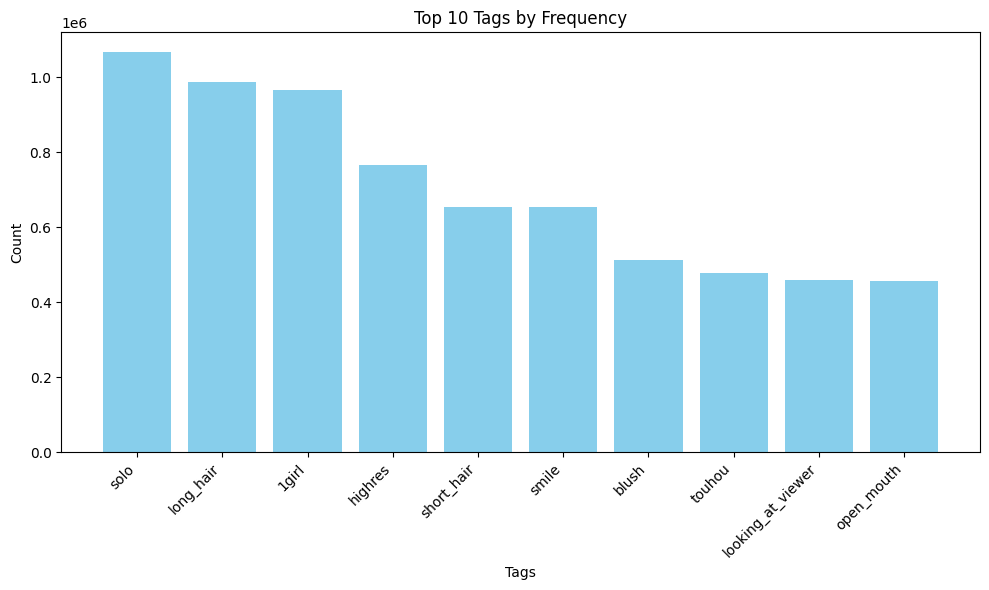

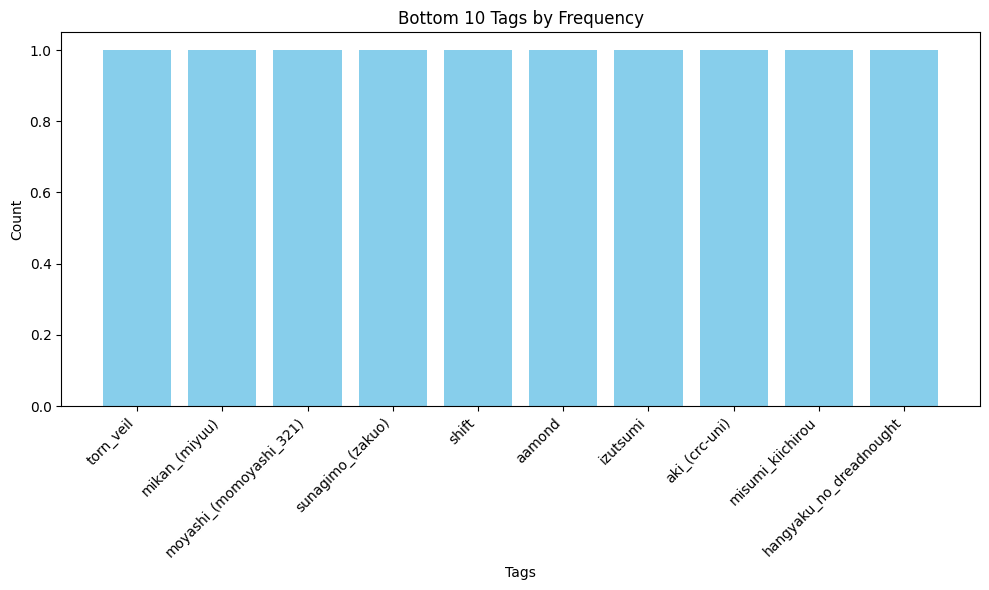

In [14]:
labels, values = zip(*top10)
labels_bottom, values_bottom = zip(*bottom10)
# Plot
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Tags")
plt.ylabel("Count")
plt.title("Top 10 Tags by Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(labels_bottom, values_bottom, color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Tags")
plt.ylabel("Count")
plt.title("Bottom 10 Tags by Frequency")
plt.tight_layout()
plt.show()


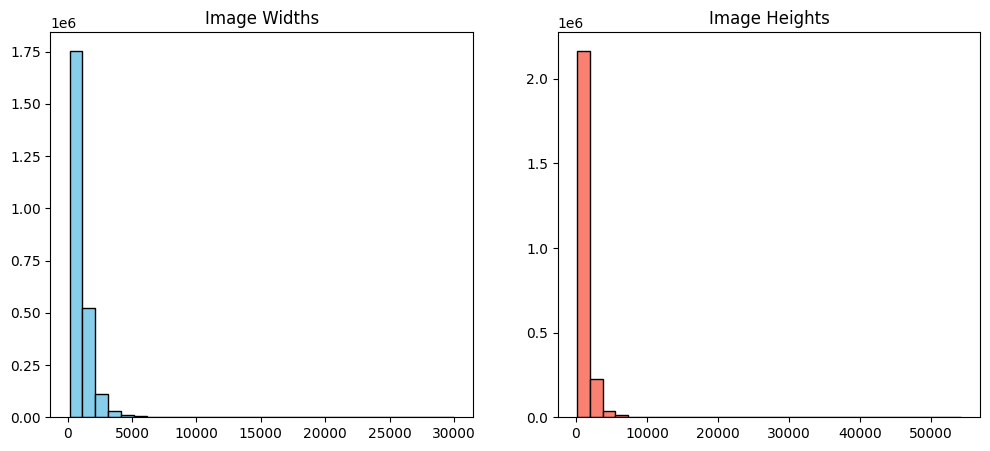

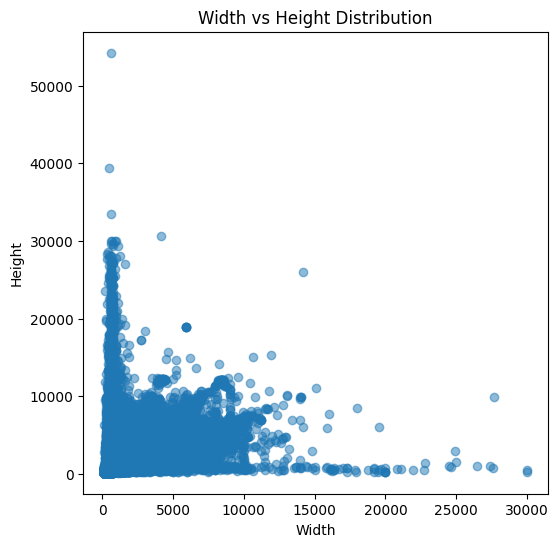

Total images checked: 2443000


In [11]:
import matplotlib.pyplot as plt
widths, heights = [], []

widths = df["width"]
heights = df["height"]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(widths, bins=30, color="skyblue", edgecolor="black")
plt.title("Image Widths")

plt.subplot(1,2,2)
plt.hist(heights, bins=30, color="salmon", edgecolor="black")
plt.title("Image Heights")

plt.show()

# Scatter plot width vs height
plt.figure(figsize=(6,6))
plt.scatter(widths, heights, alpha=0.5)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Width vs Height Distribution")
plt.show()

print(f"Total images checked: {len(widths)}")


- The majority of images are clustered in the low ranges
- But there are long tails: widths up to 30,000 px and heights up to 50,000 px.
- Those extreme values are outliers

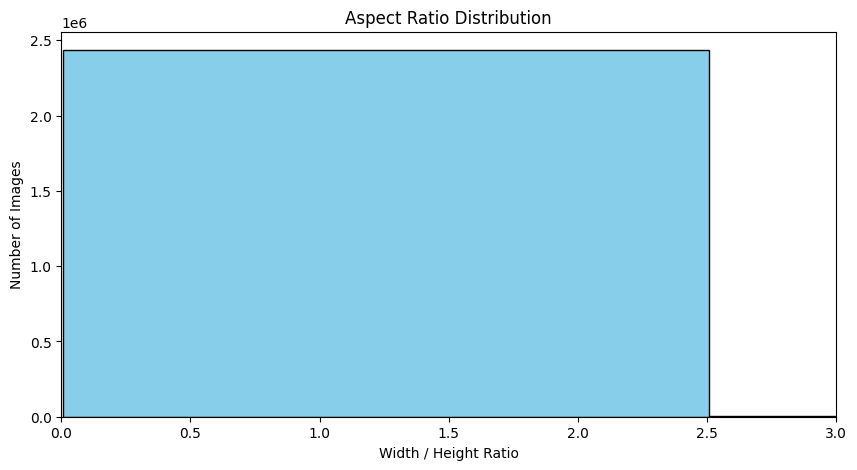

Landscape images: 626772
Portrait images: 1503055
Square-ish images: 313173


In [41]:
df["aspect_ratio"] = df["width"] / df["height"]
aspect_ratios = df["aspect_ratio"].tolist()

landscape_count = 0
portrait_count = 0
square_count = 0

for ratio in df["aspect_ratio"]:
    if ratio > 1.1:
        landscape_count += 1
    elif ratio < 0.9:
        portrait_count += 1
    else:
        square_count += 1

plt.figure(figsize=(10,5))
plt.hist(aspect_ratios, bins=50, color="skyblue", edgecolor="black")
plt.xlim(0, 3)
plt.xlabel("Width / Height Ratio")
plt.ylabel("Number of Images")
plt.title("Aspect Ratio Distribution")
plt.show()

print("Landscape images:", landscape_count)
print("Portrait images:", portrait_count)
print("Square-ish images:", square_count)

- Most of the dataset are portrait image
- Landscape is much smaller
- Square-ish is relatively small

In [44]:
import numpy as np
widths = np.array(df["width"])
heights = np.array(df["height"])

# Area
areas = widths * heights
q1, q3 = np.percentile(areas, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outlier_indices = np.where((areas < lower_bound) | (areas > upper_bound))[0]
print(f"Number of size outliers: {len(outlier_indices)}")

Number of size outliers: 257666


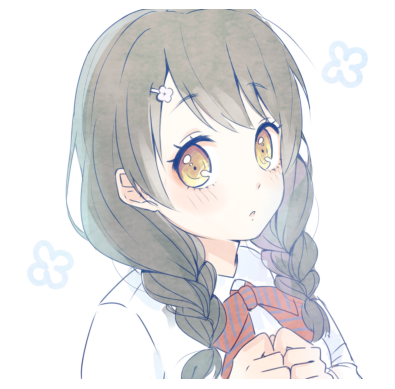

 https://safebooru.org/images/2227/56d2798700edebb9c84aa743d0d7487bc9a964af.png
   Tags:  1girl :o bangs blue_hair blush bow bowtie braid collared_shirt eyebrows_visible_through_hair face hair_ornament hairclip looking_at_viewer momoiro_danki open_mouth shirt shokugeki_no_souma simple_background solo swept_bangs tadokoro_megumi twin_braids white_background yellow_eyes 



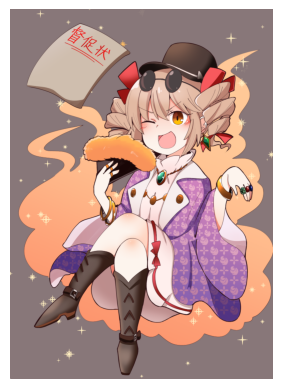

 https://safebooru.org/images/2333/0e3a94d6c3de76af02836beb9205f497f2a3d2fd.png
   Tags:  1girl ;d bangs belt belt_buckle black_belt black_footwear blush boots bow bracelet buckle buna_shimeji_(keymush) coat diamond_(shape) dress drill_hair earrings eyebrows eyebrows_visible_through_hair eyelashes eyewear_on_head facing_away fan fire full_body fur_trim gem grey_background hair_between_eyes hat hat_bow holding holding_fan jewelry legs_crossed light_brown_hair long_hair long_sleeves looking_away one_eye_closed open_clothes open_coat open_mouth orange_eyes purple_coat red_bow ring sidelocks simple_background smile solo sparkle sunglasses tongue top_hat touhou twin_drills twintails v-shaped_eyebrows white_bow white_dress wide_sleeves yorigami_jo'on 



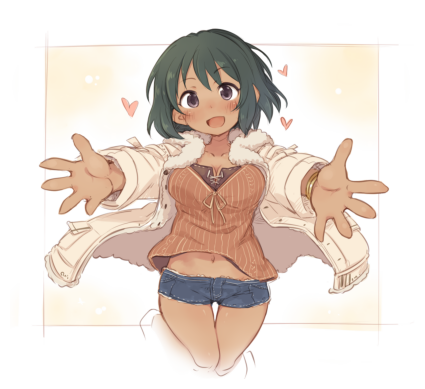

 https://safebooru.org/images/1552/d146a30b24c5a5bbb78493bf3f49b287efdb3dfa.png
   Tags:  1girl 7010 :d black_hair blush bracelet breasts cleavage coat dark_skin fur_trim heart idolmaster idolmaster_cinderella_girls jewelry large_breasts natalia_(idolmaster) navel open_mouth outstretched_arms short_hair short_shorts shorts smile solo violet_eyes 



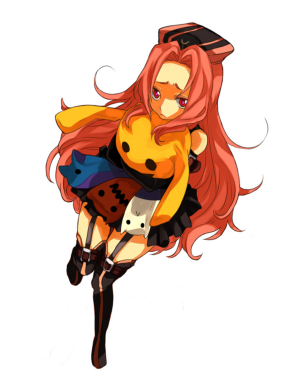

 https://safebooru.org/images/254/541c576737dac6de703712b9bf896cc58ab5f094.jpg
   Tags:  arietta bad_id boots buckle buckles cling garter_belt garter_straps hat long_hair nanamura pink_eyes pink_hair shy stuffed_animal stuffed_toy tales_of_(series) tales_of_the_abyss thigh-highs thigh_boots thighhighs yaichi 



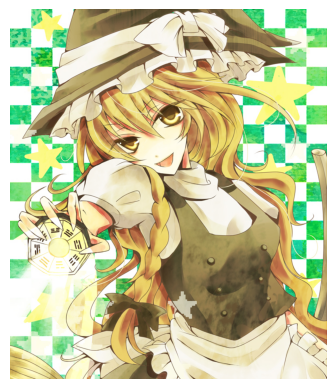

 https://safebooru.org/images/554/3e6181f5ded30e965c719f6491e833728e686a88.jpg
   Tags:  antiqua_c blonde_hair blush braid broom hat kirisame_marisa long_hair smile solo touhou witch witch_hat yellow_eyes 



In [39]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import random

def fix_url(url):
    if url.startswith("//"):
        return "https:" + url
    return url


df["file_url"] = df["file_url"].apply(fix_url)

N = 5
sampled = df.sample(n=N, random_state=random.randint(0, 9999))

# Preview sampled images with tags 
for _, row in sampled.iterrows():
    url = row["file_url"]
    tags = row["tags"]  
    
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGB")
        plt.imshow(img)
        plt.axis("off")
        plt.show()

        print(f" {url}\n   Tags: {tags}\n")

    except Exception as e:
        print(f" Could not preview {url}: {e}")
